<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/TEPQAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.6 MB/s eta 0:00:00


In [5]:
pip install qiskit

In [2]:
pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [3]:
import pandas as pd
import numpy as np

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Train.csv')

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Test.csv')

# Convert training features to numpy array and select 100 samples
train_features = train_df.to_numpy()

test_features= test_df.to_numpy()

# Create target arrays for training and testing data
test_target = np.concatenate((np.zeros(50), np.ones(10)))

# Ensure arrays are of size samples*8 (assuming 8 is the number of features)
print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of test_target: {test_target.shape}")

Shape of train_features: (200, 11)
Shape of test_features: (60, 11)
Shape of test_target: (60,)


In [18]:
# QAE using Statevector.from_instruction
# Requirements: qiskit, numpy, scipy, scikit-learn, tqdm (optional)
# Works with Qiskit >=1.2 using Statevector.from_instruction

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from tqdm import trange

# -----------------------
# Hyperparameters
# -----------------------
n_features = 11        # input features
n_qubits = n_features
n_latent = 6           # keep 6 qubits (latent)
n_trash = n_qubits - n_latent  # 5 trash qubits
reps = 2               # ansatz depth (try 1 first if slow)
batch_size = 16
maxiter = 200         # optimizer iterations (COBYLA)
seed = 42

rng = np.random.RandomState(seed)

# -----------------------
# Feature -> angle mapping
# -----------------------
def features_to_angles(X):
    """
    X: (n_samples, n_features) already scaled (StandardScaler)
    Map to angles in [-pi, pi] via tanh to avoid extreme values.
    """
    X = np.asarray(X, dtype=float)
    return np.tanh(X) * np.pi  # shape preserved

# -----------------------
# Ansatz / encoder builder
# -----------------------
def build_encoder(params):
    """
    params: length reps * n_qubits
    returns: QuantumCircuit acting on n_qubits (encoder)
    Ansatz: layer of RY per qubit (param per qubit) then CNOT ladder; repeated reps times.
    """
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for r in range(reps):
        for q in range(n_qubits):
            qc.ry(params[idx], q)
            idx += 1
        # linear entangling ladder
        for q in range(n_qubits - 1):
            qc.cx(q, q+1)
    return qc

n_params = reps * n_qubits

# -----------------------
# State preparation
# -----------------------
def prep_state_from_angles(angles):
    """
    angles: length n_qubits
    returns QuantumCircuit preparing RY(angles) on each qubit
    """
    qc = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        qc.ry(float(angles[q]), q)
    return qc

# -----------------------
# Postselection helper
# -----------------------
def postselect_zero_trash(statevec):
    """
    Given full statevector (length 2^n_qubits), project onto subspace where
    the trash qubits (highest-index qubits) are all |0>, renormalize and return
    the postselected statevector on the full register (with zeros for non-selected).
    We'll then compress by taking only components where trash bits are zero.
    """
    sv = np.asarray(statevec, dtype=complex)
    # mask indices where trash bits are zero: idx >> n_latent == 0
    mask = np.array([((idx >> n_latent) == 0) for idx in range(len(sv))])
    sel = sv[mask]
    norm = np.linalg.norm(sel)
    if norm == 0:
        # complete failure: return zeros same shape as sel
        return None, 0.0
    sel_normed = sel / norm
    return sel_normed, float(norm**2)  # return postselected state (on latent bits) and prob

# -----------------------
# Loss evaluation for a batch
# -----------------------
def evaluate_loss_batch(params, angles_batch):
    """
    params: variational params (length n_params)
    angles_batch: (batch_size, n_qubits)
    For each sample:
      1) prepare |psi> (prep)
      2) apply encoder U -> |phi> = U |psi>
      3) postselect trash=0 on |phi> -> probability p_sel and postselected state |phi_ps>
      4) construct full state by putting |phi_ps> on latent qubits + |0> on trash
      5) apply decoder U^\dagger to that reconstructed state -> |psi_rec>
      6) fidelity = |<psi | psi_rec>|^2
    Loss = 1 - mean(fidelity)
    """
    total_fid = 0.0
    encoder = build_encoder(params)
    decoder = encoder.inverse()

    for angles in angles_batch:
        # original state
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep)  # size 2^n_qubits

        # encoded state
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc)

        # postselect trash qubits = 0 -> get state on latent qubits
        sel_state, p_sel = postselect_zero_trash(phi.data)
        if sel_state is None or p_sel <= 0:
            # no amplitude in selected subspace => fidelity 0
            fid = 0.0
        else:
            # build full statevector: latent bits = sel_state, trash bits = |0...0>
            # The ordering of bits in statevector: qubit 0 is least significant.
            # Our mask selected basis states where trash bits are zero; sel_state
            # corresponds to basis over latent bits. We need to embed sel_state back to full register.
            # We'll reconstruct the full-length vector with zeros in non-selected entries.
            full_len = 2**n_qubits
            full_post = np.zeros(full_len, dtype=complex)
            # iterate over latent basis indices and place amplitude where trash bits zero
            latent_dim = 2**n_latent
            for i in range(latent_dim):
                # full index where trash are zero: i (since trash bits are upper bits)
                full_post[i] = sel_state[i]
            # now full_post is the postselected state on full register (trash bits zero)
            # apply decoder (U^\dagger)
            sv_post = Statevector(full_post)
            sv_rec = sv_post.evolve(decoder)  # reconstructed state
            # fidelity with original psi
            # psi is Statevector object
            fid = float(np.abs(np.vdot(psi.data, sv_rec.data))**2)
        total_fid += fid

    avg_fid = total_fid / len(angles_batch)
    loss = 1.0 - avg_fid
    return loss

# -----------------------
# Training routine
# -----------------------
def train_qae(X_angles, maxiter=maxiter, batch_size=batch_size):
    n = X_angles.shape[0]
    # init params small random
    init = 0.01 * rng.randn(n_params)
    # objective draws random minibatch each call
    def obj(p):
        idx = rng.choice(n, size=min(batch_size, n), replace=False)
        batch = X_angles[idx]
        return evaluate_loss_batch(p, batch)
    # Use COBYLA (gradient-free)
    res = minimize(obj, init, method='COBYLA', options={'maxiter': maxiter, 'tol': 1e-3})
    print("Optimizer success:", res.success, res.message)
    return res.x

# -----------------------
# Scoring function
# -----------------------
def qae_anomaly_scores(params, X_angles):
    """
    Compute anomaly score = 1 - fidelity for each sample in X_angles
    """
    encoder = build_encoder(params)
    decoder = encoder.inverse()
    scores = []
    for angles in X_angles:
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep)
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc)
        sel_state, p_sel = postselect_zero_trash(phi.data)
        if sel_state is None or p_sel <= 0:
            scores.append(1.0)
            continue
        latent_dim = 2**n_latent
        full_post = np.zeros(2**n_qubits, dtype=complex)
        for i in range(latent_dim):
            full_post[i] = sel_state[i]
        sv_post = Statevector(full_post)
        sv_rec = sv_post.evolve(decoder)
        fid = float(np.abs(np.vdot(psi.data, sv_rec.data))**2)
        scores.append(1.0 - fid)
    return np.array(scores)

# -----------------------
# Example usage (replace placeholders with your data)
# -----------------------
# X_train_raw: normal-only training samples shape (n_train, 11)
# X_test_raw: test samples shape (n_test, 11)
# y_test: ground-truth {0 normal, 1 anomaly} for evaluation

# Example placeholders --- replace these with real arrays
# X_train_raw = np.random.randn(200, n_features)
# X_test_raw = np.random.randn(55, n_features)
# y_test = np.concatenate((np.zeros(50), np.ones(5)))

# Pre-scale and map to angles
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_raw)
# X_test_scaled = scaler.transform(X_test_raw)
# X_train_angles = features_to_angles(X_train_scaled)
# X_test_angles = features_to_angles(X_test_scaled)

# Train
# learned_params = train_qae(X_train_angles, maxiter=200, batch_size=16)

# Score
# scores = qae_anomaly_scores(learned_params, X_test_angles)
# from sklearn.metrics import roc_auc_score
# auc = roc_auc_score(y_test, scores)
# print("QAE AUC:", auc)

# -----------------------
# Notes / tips
# -----------------------
# - For debugging, set reps=1, maxiter=50 to iterate quickly.
# - If training is slow, reduce batch_size or reps.
# - If postselection probability p_sel is extremely small (many zeros), the encoder might be collapsing wrong;
#   try increasing n_latent or reducing reps.
# - You can print loss(obj(init)) to sanity-check behavior before/after training.
# -----------------------

# Example usage (uncomment and provide your arrays):
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_raw)
X_train_angles = features_to_angles(train_features)
learned_params = train_qae(X_train_angles, maxiter=200, batch_size=32)

# # Evaluate on test
# X_test_scaled = scaler.transform(X_test_full)
X_test_angles = features_to_angles(test_features)
scores = qae_anomaly_scores(learned_params, X_test_angles)
# # higher scores -> more anomalous. Compute AUC with sklearn.metrics.roc_auc_score(y_test, scores)



<>:105: SyntaxWarning: invalid escape sequence '\d'
<>:105: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-62046883.py:105: SyntaxWarning: invalid escape sequence '\d'
  5) apply decoder U^\dagger to that reconstructed state -> |psi_rec>


Optimizer success: True Optimization terminated successfully.


In [19]:
import sklearn.metrics
print(sklearn.metrics.roc_auc_score(test_target, scores))

0.554


In [20]:
print(scores)

[0.99723214 0.69753355 0.99904731 0.97424199 0.99999678 0.85360268
 0.99213121 0.99872161 0.92984941 0.99999954 0.99968059 0.97697555
 0.99886997 0.85734707 0.99997804 0.99828775 0.99999322 0.9995769
 0.99994538 0.9999551  0.99845865 1.         0.91862249 0.99999915
 0.99530164 0.9669768  0.99310737 0.99755334 0.99678317 0.99623325
 0.80525537 0.99999563 0.99997665 0.99982351 0.99904255 0.95334542
 0.93239878 0.99959767 0.95805935 0.999866   0.99905963 0.99901678
 0.93006441 0.96217036 0.87998244 0.95931521 0.9964843  0.96370271
 0.99922634 0.99655568 0.99868418 0.98618282 0.99855462 0.97826606
 0.99986161 0.97701687 0.9931399  0.99806347 0.99989298 0.99999581]


In [21]:
# QAE using Statevector.from_instruction
# Requirements: qiskit, numpy, scipy, scikit-learn, tqdm (optional)
# Works with Qiskit >=1.2 using Statevector.from_instruction

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from tqdm import trange

# -----------------------
# Hyperparameters
# -----------------------
n_features = 11        # input features
n_qubits = n_features
n_latent = 6           # keep 6 qubits (latent)
n_trash = n_qubits - n_latent  # 5 trash qubits
reps = 2               # ansatz depth (try 1 first if slow)
batch_size = 16
maxiter = 200         # optimizer iterations (COBYLA)
seed = 42

rng = np.random.RandomState(seed)

# -----------------------
# Feature -> angle mapping
# -----------------------
def features_to_angles(X):
    """
    X: (n_samples, n_features) already scaled (StandardScaler)
    Map to angles in [-pi, pi] via tanh to avoid extreme values.
    """
    X = np.asarray(X, dtype=float)
    return np.tanh(X) * np.pi  # shape preserved

# -----------------------
# Ansatz / encoder builder
# -----------------------
def build_encoder(params):
    """
    params: length reps * n_qubits
    returns: QuantumCircuit acting on n_qubits (encoder)
    Ansatz: layer of RY per qubit (param per qubit) then CNOT ladder; repeated reps times.
    """
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for r in range(reps):
        for q in range(n_qubits):
            qc.ry(params[idx], q)
            idx += 1
        # linear entangling ladder
        for q in range(n_qubits - 1):
            qc.cx(q, q+1)
    return qc

n_params = reps * n_qubits

# -----------------------
# State preparation
# -----------------------
def prep_state_from_angles(angles):
    """
    angles: length n_qubits
    returns QuantumCircuit preparing RY(angles) on each qubit
    """
    qc = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        qc.ry(float(angles[q]), q)
    return qc

# -----------------------
# Postselection helper
# -----------------------
def postselect_zero_trash(statevec):
    """
    Given full statevector (length 2^n_qubits), project onto subspace where
    the trash qubits (highest-index qubits) are all |0>, renormalize and return
    the postselected statevector on the full register (with zeros for non-selected).
    We'll then compress by taking only components where trash bits are zero.
    """
    sv = np.asarray(statevec, dtype=complex)
    # mask indices where trash bits are zero: idx >> n_latent == 0
    mask = np.array([((idx >> n_latent) == 0) for idx in range(len(sv))])
    sel = sv[mask]
    norm = np.linalg.norm(sel)
    if norm == 0:
        # complete failure: return zeros same shape as sel
        return None, 0.0
    sel_normed = sel / norm
    return sel_normed, float(norm**2)  # return postselected state (on latent bits) and prob

# -----------------------
# Loss evaluation for a batch
# -----------------------
def evaluate_loss_batch(params, angles_batch):
    """
    params: variational params (length n_params)
    angles_batch: (batch_size, n_qubits)
    For each sample:
      1) prepare |psi> (prep)
      2) apply encoder U -> |phi> = U |psi>
      3) postselect trash=0 on |phi> -> probability p_sel and postselected state |phi_ps>
      4) construct full state by putting |phi_ps> on latent qubits + |0> on trash
      5) apply decoder U^\dagger to that reconstructed state -> |psi_rec>
      6) fidelity = |<psi | psi_rec>|^2
    Loss = 1 - mean(fidelity)
    """
    total_fid = 0.0
    encoder = build_encoder(params)
    decoder = encoder.inverse()

    for angles in angles_batch:
        # original state
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep)  # size 2^n_qubits

        # encoded state
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc)

        # postselect trash qubits = 0 -> get state on latent qubits
        sel_state, p_sel = postselect_zero_trash(phi.data)
        if sel_state is None or p_sel <= 0:
            # no amplitude in selected subspace => fidelity 0
            fid = 0.0
        else:
            # build full statevector: latent bits = sel_state, trash bits = |0...0>
            # The ordering of bits in statevector: qubit 0 is least significant.
            # Our mask selected basis states where trash bits are zero; sel_state
            # corresponds to basis over latent bits. We need to embed sel_state back to full register.
            # We'll reconstruct the full-length vector with zeros in non-selected entries.
            full_len = 2**n_qubits
            full_post = np.zeros(full_len, dtype=complex)
            # iterate over latent basis indices and place amplitude where trash bits zero
            latent_dim = 2**n_latent
            for i in range(latent_dim):
                # full index where trash are zero: i (since trash bits are upper bits)
                full_post[i] = sel_state[i]
            # now full_post is the postselected state on full register (trash bits zero)
            # apply decoder (U^\dagger)
            sv_post = Statevector(full_post)
            sv_rec = sv_post.evolve(decoder)  # reconstructed state
            # fidelity with original psi
            # psi is Statevector object
            fid = float(np.abs(np.vdot(psi.data, sv_rec.data))**2)
        total_fid += fid

    avg_fid = total_fid / len(angles_batch)
    loss = 1.0 - avg_fid
    return loss

# -----------------------
# Training routine
# -----------------------
def train_qae(X_angles, maxiter=maxiter, batch_size=batch_size):
    n = X_angles.shape[0]
    init = 0.01 * rng.randn(n_params)
    loss_history = []

    def obj(p):
        idx = rng.choice(n, size=min(batch_size, n), replace=False)
        batch = X_angles[idx]
        L = evaluate_loss_batch(p, batch)
        loss_history.append(L)
        return L

    res = minimize(obj, init, method='COBYLA',
                   options={'maxiter': maxiter, 'tol': 1e-3})
    print("Optimizer success:", res.success, res.message)

    return res.x, loss_history

# -----------------------
# Scoring function
# -----------------------
def qae_anomaly_scores(params, X_angles):
    """
    Compute anomaly score = 1 - fidelity for each sample in X_angles
    """
    encoder = build_encoder(params)
    decoder = encoder.inverse()
    scores = []
    for angles in X_angles:
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep)
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc)
        sel_state, p_sel = postselect_zero_trash(phi.data)
        if sel_state is None or p_sel <= 0:
            scores.append(1.0)
            continue
        latent_dim = 2**n_latent
        full_post = np.zeros(2**n_qubits, dtype=complex)
        for i in range(latent_dim):
            full_post[i] = sel_state[i]
        sv_post = Statevector(full_post)
        sv_rec = sv_post.evolve(decoder)
        fid = float(np.abs(np.vdot(psi.data, sv_rec.data))**2)
        scores.append(1.0 - fid)
    return np.array(scores)

# -----------------------
# Example usage (replace placeholders with your data)
# -----------------------
# X_train_raw: normal-only training samples shape (n_train, 11)
# X_test_raw: test samples shape (n_test, 11)
# y_test: ground-truth {0 normal, 1 anomaly} for evaluation

# Example placeholders --- replace these with real arrays
# X_train_raw = np.random.randn(200, n_features)
# X_test_raw = np.random.randn(55, n_features)
# y_test = np.concatenate((np.zeros(50), np.ones(5)))

# Pre-scale and map to angles
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_raw)
# X_test_scaled = scaler.transform(X_test_raw)
# X_train_angles = features_to_angles(X_train_scaled)
# X_test_angles = features_to_angles(X_test_scaled)

# Train
# learned_params = train_qae(X_train_angles, maxiter=200, batch_size=16)

# Score
# scores = qae_anomaly_scores(learned_params, X_test_angles)
# from sklearn.metrics import roc_auc_score
# auc = roc_auc_score(y_test, scores)
# print("QAE AUC:", auc)

# -----------------------
# Notes / tips
# -----------------------
# - For debugging, set reps=1, maxiter=50 to iterate quickly.
# - If training is slow, reduce batch_size or reps.
# - If postselection probability p_sel is extremely small (many zeros), the encoder might be collapsing wrong;
#   try increasing n_latent or reducing reps.
# - You can print loss(obj(init)) to sanity-check behavior before/after training.
# -----------------------

# Example usage (uncomment and provide your arrays):
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_raw)
X_train_angles = features_to_angles(train_features)
learned_params, loss_history = train_qae(X_train_angles, maxiter=200)

# # Evaluate on test
# X_test_scaled = scaler.transform(X_test_full)
X_test_angles = features_to_angles(test_features)
scores = qae_anomaly_scores(learned_params, X_test_angles)
# # higher scores -> more anomalous. Compute AUC with sklearn.metrics.roc_auc_score(y_test, scores)



<>:105: SyntaxWarning: invalid escape sequence '\d'
<>:105: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3623955628.py:105: SyntaxWarning: invalid escape sequence '\d'
  5) apply decoder U^\dagger to that reconstructed state -> |psi_rec>


Optimizer success: True Optimization terminated successfully.


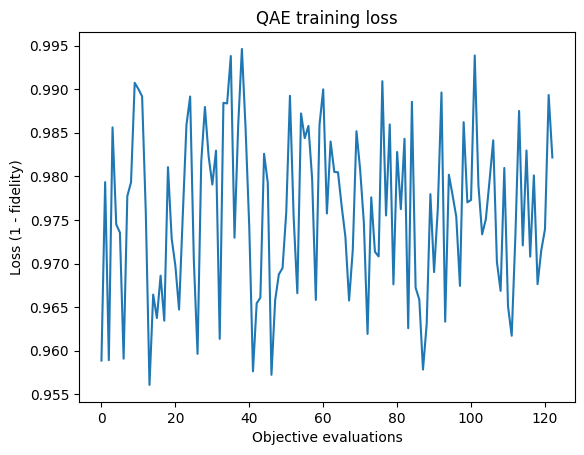

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Objective evaluations")
plt.ylabel("Loss (1 - fidelity)")
plt.title("QAE training loss")
plt.show()

In [23]:
import sklearn.metrics
print(sklearn.metrics.roc_auc_score(test_target, scores))

0.5660000000000001


SPSA: 100%|██████████| 400/400 [02:54<00:00,  2.29it/s]


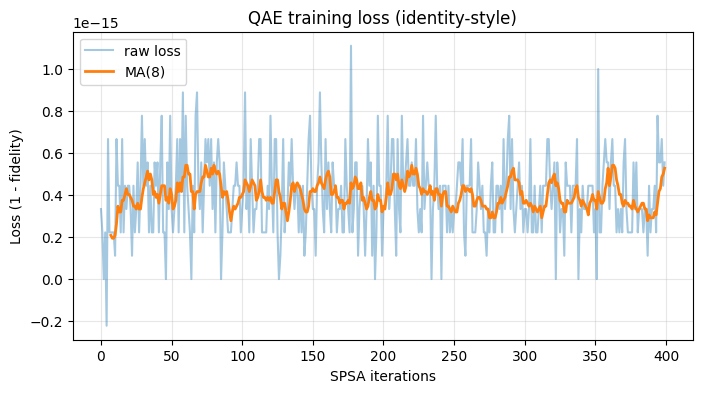

QAE AUC: 0.401


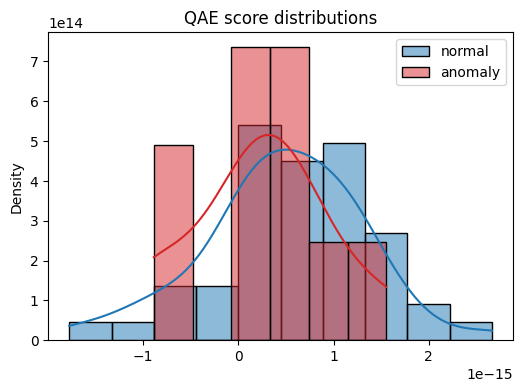

In [35]:
# Identity-style QAE (1-b): 11 input features + 1 ancilla = 12 qubits total
# Uses Statevector.from_instruction for exact statevector ops and SPSA for training.
# Requirements: qiskit, numpy, scipy, sklearn, matplotlib, tqdm
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------------
# Hyperparameters (tweakable)
# -----------------------------
n_input = 11            # number of features
n_qubits = 12           # n_input + 1 ancilla
ancilla_index = n_qubits - 1  # last qubit is ancilla, stays |0>
reps = 1                # ansatz depth (try 1 first if slow)
n_params = reps * n_qubits
batch_size = 16
maxiter = 400           # SPSA iterations (each iteration = 2 obj evals)
seed = 123
rng = np.random.RandomState(seed)

# SPSA hyperparameters (sensible defaults)
spsa_a = 0.3
spsa_c = 0.05
spsa_A = 0.1 * maxiter
spsa_alpha = 0.602
spsa_gamma = 0.101

# -----------------------------
# Utilities: angles and circuits
# -----------------------------
def features_to_angles(X):
    """
    X: (n_samples, n_input) already scaled by StandardScaler
    maps to angles in [-pi, pi] using tanh for safety
    """
    X = np.asarray(X, dtype=float)
    return np.tanh(X) * np.pi

def prep_state_from_angles(angles):
    """
    Prepare RY(angles[i]) on qubit i for i in [0, n_input-1].
    Ancilla qubit left in |0>.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_input):
        qc.ry(float(angles[i]), i)
    # ancilla qubit remains |0>
    return qc

def build_encoder(params):
    """
    params: length n_params (reps * n_qubits)
    Ansatz: for each rep: RY on each qubit (including ancilla) with param,
    then CNOT ladder across all qubits (linear entanglement).
    """
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for r in range(reps):
        for q in range(n_qubits):
            qc.ry(float(params[idx]), q)
            idx += 1
        # linear entangling CNOT ladder
        for q in range(n_qubits - 1):
            qc.cx(q, q + 1)
    return qc

# -----------------------------
# Loss evaluation (identity-style)
# -----------------------------
def fidelity_between_states(sv_a, sv_b):
    """sv_a, sv_b: numpy arrays (statevectors)"""
    return float(np.abs(np.vdot(sv_a, sv_b))**2)

def evaluate_loss_batch(params, angles_batch):
    """
    params: variational params (length n_params)
    angles_batch: array (batch_size, n_input)
    Returns: average loss = 1 - average fidelity
    """
    total_fid = 0.0
    encoder = build_encoder(params)
    decoder = encoder.inverse()
    for angles in angles_batch:
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep).data         # original statevector
        # encode
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc).data
        # decode (apply decoder to encoded state)
        # we can evolve using Statevector.evolve but .evolve accepts circuit object
        sv_phi = Statevector(phi)
        sv_rec = sv_phi.evolve(decoder)   # reconstructed statevector
        fid = fidelity_between_states(psi, sv_rec.data)
        total_fid += fid
    avg_fid = total_fid / len(angles_batch)
    return 1.0 - avg_fid

# -----------------------------
# SPSA trainer (vectorized wrapper)
# -----------------------------
def spsa_train(obj_fn, X_angles, init_params=None, maxiter=maxiter,
               a=spsa_a, c=spsa_c, A=spsa_A, alpha=spsa_alpha, gamma=spsa_gamma,
               batch_size=batch_size, seed=seed):
    rng_local = np.random.RandomState(seed)
    n = X_angles.shape[0]
    if init_params is None:
        params = 0.01 * rng_local.randn(n_params)
    else:
        params = init_params.copy()

    loss_history = []
    params_history = []

    def draw_batch():
        idx = rng_local.choice(n, size=min(batch_size, n), replace=False)
        return X_angles[idx]

    for k in trange(int(maxiter), desc="SPSA"):
        ak = a / ((k + 1 + A) ** alpha)
        ck = c / ((k + 1) ** gamma)
        delta = rng_local.choice([-1.0, 1.0], size=params.shape)

        p_plus = params + ck * delta
        p_minus = params - ck * delta

        batch = draw_batch()
        y_plus = obj_fn(p_plus, batch)
        y_minus = obj_fn(p_minus, batch)

        ghat = (y_plus - y_minus) / (2.0 * ck) * delta
        params = params - ak * ghat

        # monitor: evaluate on another random batch (validation-like)
        val_batch = draw_batch()
        val_loss = obj_fn(params, val_batch)
        loss_history.append(val_loss)
        params_history.append(params.copy())

    return params, np.array(loss_history), np.array(params_history)

# -----------------------------
# Scoring function
# -----------------------------
def qae_scores(params, X_angles):
    """Compute anomaly scores (1 - fidelity) for each sample in X_angles"""
    encoder = build_encoder(params)
    decoder = encoder.inverse()
    scores = []
    for angles in X_angles:
        prep = prep_state_from_angles(angles)
        psi = Statevector.from_instruction(prep).data
        circ_enc = prep.compose(encoder)
        phi = Statevector.from_instruction(circ_enc).data
        sv_phi = Statevector(phi)
        sv_rec = sv_phi.evolve(decoder)
        fid = fidelity_between_states(psi, sv_rec.data)
        scores.append(1.0 - fid)
    return np.array(scores)

# -----------------------------
# Example usage (replace these placeholders)
# -----------------------------
# Replace these with your actual arrays:
# - X_train_raw: normal-only training data shape (n_train, 11)
# - X_test_raw: test data (mix normal + anomalies) shape (n_test, 11)
# - y_test: binary labels (0 normal, 1 anomaly), length n_test

# Example placeholders (for quick dry run) -- replace them!
# X_train_raw = np.random.normal(0,1,(200, n_input))
# X_test_raw  = np.random.normal(0,1,(55, n_input))
# y_test = np.concatenate([np.zeros(50), np.ones(5)])

# ---------- uncomment & replace with your data ----------
# scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_raw)
#X_test_scaled  = scaler.transform(X_test_raw)
X_train_angles = features_to_angles(train_features)
X_test_angles  = features_to_angles(test_features)



# # Train with SPSA
learned_params, loss_hist, params_hist = spsa_train(
     obj_fn=evaluate_loss_batch,
     X_angles=X_train_angles,
     init_params=None,
     maxiter=400,
     a=0.3, c=0.05, batch_size=16, seed=seed
 )

# # Plot training loss (raw + moving average)
plt.figure(figsize=(8,4))
plt.plot(loss_hist, alpha=0.4, label='raw loss')
window = max(3, len(loss_hist)//50)
ma = np.convolve(loss_hist, np.ones(window)/window, mode='valid')
plt.plot(np.arange(window-1, window-1+len(ma)), ma, color='C1', linewidth=2, label=f'MA({window})')
plt.xlabel("SPSA iterations")
plt.ylabel("Loss (1 - fidelity)")
plt.title("QAE training loss (identity-style)")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# # Score test set & compute AUC
scores = qae_scores(learned_params, X_test_angles)
auc = roc_auc_score(test_target, scores)
print("QAE AUC:", auc)

# # visualize score distributions
import seaborn as sns
plt.figure(figsize=(6,4))
sns.histplot(scores[test_target==0], label='normal', stat='density', kde=True)
sns.histplot(scores[test_target==1], label='anomaly', stat='density', kde=True, color='C3')
plt.legend(); plt.title("QAE score distributions"); plt.show()


In [36]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_target, scores)
print("AUC (current):", auc)
# try inverted
auc_inv = roc_auc_score((test_target), -scores)
print("AUC (inverted):", auc_inv)

AUC (current): 0.401
AUC (inverted): 0.599


In [37]:
# compute fidelities rather than scores (scores = 1-fid)
def compute_fid_array(params, X_angles):
    from qiskit.quantum_info import Statevector
    encoder = build_encoder(params)
    decoder = encoder.inverse()
    fids = []
    for ang in X_angles:
        prep = prep_state_from_angles(ang)
        psi = Statevector.from_instruction(prep).data
        phi = Statevector.from_instruction(prep.compose(encoder)).data
        sv_rec = Statevector(phi).evolve(decoder)
        fids.append(np.abs(np.vdot(psi, sv_rec.data))**2)
    return np.array(fids)

fids_test = compute_fid_array(learned_params, X_test_angles)
print("mean fid all test:", fids_test.mean())
print("mean fid normals:", fids_test[test_target==0].mean(), " count:", (test_target==0).sum())
print("mean fid anomalies:", fids_test[test_target==1].mean(), " count:", (test_target==1).sum())

mean fid all test: 0.9999999999999997
mean fid normals: 0.9999999999999996  count: 50
mean fid anomalies: 0.9999999999999998  count: 10
